#### Importing Librarires 

In [1]:
import gym
import sys
import sys
import random

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
from torch.distributions.categorical import Categorical
from sklearn.preprocessing import normalize

import math as mt
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import *
from qiskit import transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import *
import qiskit_machine_learning
from qiskit_machine_learning.neural_networks import SamplerQNN, CircuitQNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_ibm_runtime import Options

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
options = Options()
options.simulator.seed_simulator = seed'''

enviroment = gym.make("CartPole-v1").unwrapped
backend = qiskit.Aer.get_backend('qasm_simulator')

In [3]:
class HybridActorNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 number_of_qubits = 1,
                 number_of_shots = 1024):
        super(HybridActorNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.number_of_qubits = number_of_qubits
        self.number_of_shots = number_of_shots

        self.qubits = [i for i in range(0, self.number_of_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self.beta = qiskit.circuit.ParameterVector('beta', self.state_space)

        QuantumBits=qiskit.QuantumRegister(self.number_of_qubits)
        ClassicalBits=qiskit.ClassicalRegister(self.number_of_qubits)
        self.quantum_circuit = qiskit.QuantumCircuit(QuantumBits,
                                                     ClassicalBits)

        self.input_layer()
        self.parameterized_quantum_circuit()
        self.quantum_circuit.measure(QuantumBits,
                                     ClassicalBits)
        quantum_instance = QuantumInstance(backend = backend,
                                           shots = self.number_of_shots)
        quantum_neural_network = CircuitQNN(circuit = self.quantum_circuit,
                                            input_params = self.beta.params,
                                            weight_params = [self.theta],
                                            input_gradients = False,
                                            quantum_instance = quantum_instance)
        
        self.quantum_layer = TorchConnector(quantum_neural_network)

        self.classical_layer_1 = nn.Linear(64, self.action_space)

    def input_layer(self):
        self.quantum_circuit.h(self.qubits)
        self.quantum_circuit.barrier()

        self.quantum_circuit.rz(self.beta[0], self.qubits)
        self.quantum_circuit.ry(self.beta[1], self.qubits)
        self.quantum_circuit.rz(self.beta[2], self.qubits)
        self.quantum_circuit.barrier()

    def parameterized_quantum_circuit(self):
        self.quantum_circuit.rx(self.theta, self.qubits)
        self.quantum_circuit.barrier()

    def forward(self, current_state):

        output_layer_1 = self.quantum_layer(current_state)
        output_layer_1 = (output_layer_1[0]-output_layer_1[1]).repeat(64)
        output_layer_2 = F.relu(self.classical_layer_1(output_layer_1))
        
        policy = Categorical(F.softmax(output_layer_2, dim=-1))
        return policy

In [4]:
class HybridCriticNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 number_of_qubits = 1,
                 number_of_shots = 1024):
        super(HybridCriticNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.number_of_qubits = number_of_qubits
        self.number_of_shots = number_of_shots
        self.qubits = [i for i in range(0, self.number_of_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self.beta = qiskit.circuit.ParameterVector('beta', self.state_space)

        QuantumBits=qiskit.QuantumRegister(self.number_of_qubits)
        ClassicalBits=qiskit.ClassicalRegister(self.number_of_qubits)
        self.quantum_circuit = qiskit.QuantumCircuit(QuantumBits,
                                                     ClassicalBits)

        self.input_layer()
        self.parameterized_quantum_circuit()
        self.quantum_circuit.measure(QuantumBits,
                                     ClassicalBits)
        
        quantum_instance = QuantumInstance(backend = backend,
                                           shots = self.number_of_shots)
        quantum_neural_network = CircuitQNN(circuit = self.quantum_circuit,
                                            input_params = self.beta.params,
                                            weight_params = [self.theta],
                                            input_gradients = True,
                                            quantum_instance = quantum_instance)
        
        self.quantum_layer = TorchConnector(quantum_neural_network)

        self.classical_layer_1 = nn.Linear(64, 1)

    def input_layer(self):
        self.quantum_circuit.h(self.qubits)
        self.quantum_circuit.barrier()

        self.quantum_circuit.rz(self.beta[0], self.qubits)
        self.quantum_circuit.ry(self.beta[1], self.qubits)
        self.quantum_circuit.rz(self.beta[2], self.qubits)
        self.quantum_circuit.barrier()

    def parameterized_quantum_circuit(self):
        self.quantum_circuit.rx(self.theta, self.qubits)
        self.quantum_circuit.barrier()

    def forward(self, current_state):

        output_layer_1 = self.quantum_layer(current_state)
        output_layer_1 = (output_layer_1[0]-output_layer_1[1]).repeat(64)
        state_value = self.classical_layer_1(output_layer_1)
    
        return state_value

In [ ]:
class QERL_Agent():
    def __init__(self, 
                 Actor,
                 Critic,
                 max_time_steps,
                 actor_learning_rate,
                 critic_learning_rate,
                 discount_factor,
                 number_of_epochs):
        
        self.max_time_steps = max_time_steps
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.discount_factor = discount_factor
        self.number_of_epochs = number_of_epochs

        self.Actor = Actor
        self.Critic = Critic

        self.actor_optimizer = optim.Adam(self.Actor.parameters(), self.actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.Critic.parameters(), self.critic_learning_rate)

    def clear_memory(self):
        self.rewards = []
        self.state_values = []
        self.log_policies = []
        self.done = []

    def replay_memory(self, 
                      state_value,
                      reward,
                      policy,
                      done):
        
        self.log_policies.append(policy)
        self.state_values.append(state_value)
        self.rewards.append(torch.tensor([reward],
                                         dtype = torch.float,
                                         device = device))
        self.done.append(torch.tensor([1-done],
                                      dtype = torch.float,
                                      device = device))
        
    def action_selection(self, 
                         current_state):
        current_state = torch.FloatTensor(current_state).to(device)
        policy = self.Actor(current_state)
        action = policy.sample()
        policy = policy.log_prob(action).unsqueeze(0)

        return action.cpu().numpy(), policy
    
    def compute_discounted_rewards(self, 
                                   next_state_value):
        R = next_state_value
        discounted_rewards = []
        for step in reversed(range(len(self.rewards))):
            R = self.rewards[step] + self.discount_factor * R * self.done[step]
            discounted_rewards.insert(0, R)
        return discounted_rewards
    
    def loss_function(self,
                      discounted_rewards):
        
        self.log_policies = torch.cat(self.log_policies)
        discounted_rewards = torch.cat(discounted_rewards).detach()
        self.state_values = torch.cat(self.state_values)

        advantage = discounted_rewards - self.state_values
        actor_loss = -(self.log_policies * advantage.detach()).mean()
        critic_loss = F.huber_loss(discounted_rewards, self.state_values)

        return actor_loss, critic_loss
    
    def training(self, next_state_value):
        discounted_rewards = self.compute_discounted_rewards(next_state_value)
        actor_loss, critic_loss = self.loss_function(discounted_rewards)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()


        return actor_loss.item(), critic_loss.item()

In [6]:
def data_transformation(state):
        return [mt.atan(i) for i in state] 

In [7]:
state_space = enviroment.observation_space.shape[0]-1
action_space = enviroment.action_space.n

actor_learning_rate = 0.02
critic_learning_rate = 0.2

max_time_steps = 500
number_of_epochs = 1
number_of_episodes = 500
discount_factor = 0.99
constant_for_average = 10

Actor = HybridActorNetwork(state_space = state_space,
                     action_space = action_space).to(device)
Critic = HybridCriticNetwork(state_space = state_space,
                       action_space = action_space).to(device)
Agent = QERL_Agent(Actor = Actor,
                        Critic = Critic,
                        max_time_steps = max_time_steps,
                        discount_factor = discount_factor,
                        actor_learning_rate = actor_learning_rate,
                        critic_learning_rate = critic_learning_rate,
                        number_of_epochs = number_of_epochs)

score = []
actor_loss = []
critic_loss = []

average_score = []
average_actor_loss = []
average_critic_loss = []

for current_episode in range(0, number_of_episodes):
    Agent.clear_memory()
    (current_state, _ ) = enviroment.reset()
    episodic_score  = 0

    for time_step in range(0, max_time_steps):
        enviroment.render()
        current_state = data_transformation(state = current_state[1:4])
        action, policy = Agent.action_selection(current_state)
        current_state = torch.FloatTensor(current_state).to(device)
        state_value = Critic(current_state)

        next_state, reward, done, info, _ = enviroment.step(action)
        episodic_score += reward

        Agent.replay_memory(reward = reward,
                            policy = policy,
                            state_value = state_value,
                            done = done)
        
        current_state = next_state
        if done == True:
            break

    next_state = data_transformation(state = next_state[1:4])
    next_state = torch.FloatTensor(next_state).to(device)
    next_state_value = Critic(next_state)
    episodic_actor_loss, episodic_critic_loss = Agent.training(next_state_value = next_state_value)

    score.append(episodic_score)
    actor_loss.append(episodic_actor_loss)
    critic_loss.append(episodic_critic_loss)
    print('Episode:{} Score:{} Actor_Loss:{} Critic_Loss:{}'.format(current_episode, 
                                                                    episodic_score, 
                                                                    episodic_actor_loss, 
                                                                    episodic_critic_loss))
    
for i in range(0,int(len(score)/constant_for_average)):
    temp_score = sum(score[i * constant_for_average : (i+1) * constant_for_average])
    temp_actor_loss = sum(actor_loss[i * constant_for_average : (i+1) * constant_for_average])
    temp_critic_loss = sum(critic_loss[i * constant_for_average : (i+1) * constant_for_average])

    average_score.append(temp_score/10)
    average_actor_loss.append(temp_actor_loss/10)
    average_critic_loss.append(temp_critic_loss/10)

/var/folders/5d/v7pmycsx3ld6mf_2fksw9vzc0000gn/T/ipykernel_71069/1355134908.py:26: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend = backend,
/Users/zam026/Dropbox/CSIRO/Projects/QRL for CartPole/Python Codes/PyTorch and Qiskit/.venv/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode:0 Score:14.0 Actor_Loss:5.139144420623779 Critic_Loss:6.6523003578186035
Episode:1 Score:9.0 Actor_Loss:3.131927967071533 Critic_Loss:3.507538318634033


/Users/zam026/Dropbox/CSIRO/Projects/QRL for CartPole/Python Codes/PyTorch and Qiskit/.venv/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode:2 Score:48.0 Actor_Loss:14.410446166992188 Critic_Loss:20.414386749267578
Episode:3 Score:17.0 Actor_Loss:7.999631881713867 Critic_Loss:11.05884075164795
Episode:4 Score:14.0 Actor_Loss:3.5956614017486572 Critic_Loss:4.953354835510254
Episode:5 Score:37.0 Actor_Loss:11.33658504486084 Critic_Loss:15.981364250183105
Episode:6 Score:29.0 Actor_Loss:8.087885856628418 Critic_Loss:11.222709655761719
Episode:7 Score:58.0 Actor_Loss:14.200017929077148 Critic_Loss:21.69138526916504
Episode:8 Score:21.0 Actor_Loss:6.0217156410217285 Critic_Loss:8.163647651672363
Episode:9 Score:18.0 Actor_Loss:5.167199611663818 Critic_Loss:7.381771564483643
Episode:10 Score:52.0 Actor_Loss:13.065876007080078 Critic_Loss:19.27348518371582
Episode:11 Score:48.0 Actor_Loss:12.264313697814941 Critic_Loss:18.590778350830078
Episode:12 Score:20.0 Actor_Loss:5.190560340881348 Critic_Loss:7.3473711013793945
Episode:13 Score:37.0 Actor_Loss:9.3223237991333 Critic_Loss:13.586788177490234
Episode:14 Score:15.0 Acto

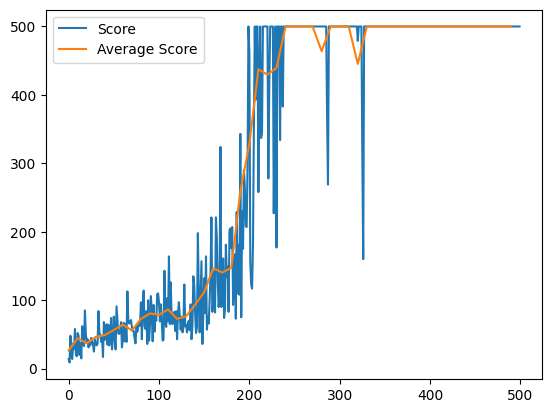

In [8]:
plt.plot(np.array(list(range(0, len(score)))), score, label='Score')
plt.plot(np.array(list(range(0, len(score), constant_for_average))), average_score, label='Average Score')
plt.legend()
plt.show()

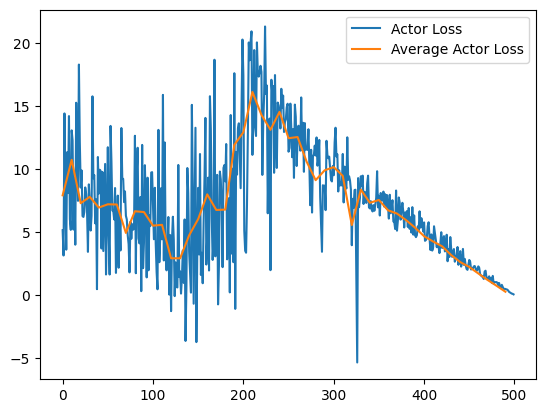

In [9]:
plt.plot(np.array(list(range(0, len(actor_loss)))), actor_loss, label='Actor Loss')
plt.plot(np.array(list(range(0, len(actor_loss), constant_for_average))), average_actor_loss, label='Average Actor Loss')
plt.legend()
plt.show()

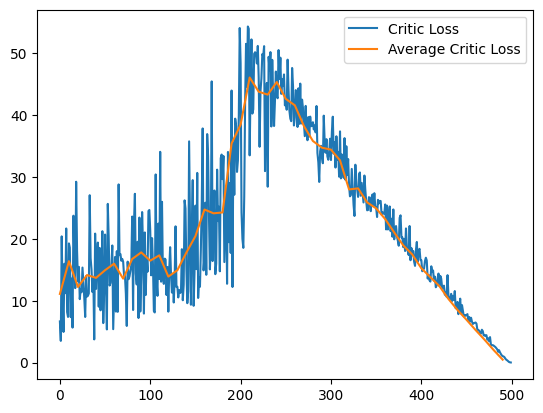

In [10]:
plt.plot(np.array(list(range(0, len(critic_loss)))), critic_loss, label='Critic Loss')
plt.plot(np.array(list(range(0, len(critic_loss), constant_for_average))), average_critic_loss, label='Average Critic Loss')
plt.legend()
plt.show()

In [ ]:

'''file = open("Quantum_Score_Loss_V15(1_CNN_qasm).txt", "x")
data = np.column_stack([score, actor_loss, critic_loss])
np.savetxt("Quantum_Score_Loss_V15(1_CNN_qasm).txt",data)'''

In [ ]:
'''file = open("Quantum_Score_Loss_V1(1_CNN_qasm_1500_epsiodes).txt", "x")
data = np.column_stack([score, actor_loss, critic_loss])
np.savetxt("Quantum_Score_Loss_V1(1_CNN_qasm_1500_episodes).txt",data)'''

In [11]:
total_params = sum(p.numel() for p in Actor.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 131


In [12]:
total_params = sum(p.numel() for p in Critic.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 66


In [13]:
torch.save(Actor.state_dict(), 'Actor_weights_V1.pth')

In [14]:
torch.save(Actor.state_dict(), 'Critic_weights_V1.pth')

In [15]:
Actor1 = HybridActorNetwork(state_space = state_space,
                            action_space = action_space).to(device)

/var/folders/5d/v7pmycsx3ld6mf_2fksw9vzc0000gn/T/ipykernel_71069/1355134908.py:26: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend = backend,


In [20]:
Actor1.load_state_dict(torch.load("Actor_weights_V1.pth"))

<All keys matched successfully>

In [21]:
Actor1.state_dict()

OrderedDict([('quantum_layer.weight', tensor([2.3464])),
             ('quantum_layer._weights', tensor([2.3464])),
             ('classical_layer_1.weight',
              tensor([[-0.4933, -0.4795, -0.6510, -0.6290, -0.4794, -0.6119, -0.4686, -0.5171,
                       -0.4220, -0.5964, -0.5980, -0.5146, -0.4314, -0.5529, -0.4661, -0.5879,
                       -0.4363, -0.5477, -0.4487, -0.5589, -0.5851, -0.6124, -0.4818, -0.6329,
                       -0.5833, -0.4243, -0.4337, -0.5083, -0.6088, -0.4724, -0.6054, -0.5366,
                       -0.6555, -0.4840, -0.4691, -0.4761, -0.5635, -0.5897, -0.4877, -0.6473,
                       -0.5567, -0.5021, -0.5275, -0.6440, -0.5212, -0.6313, -0.6382, -0.4833,
                       -0.5122, -0.5283, -0.4386, -0.5911, -0.5132, -0.5505, -0.5363, -0.5703,
                       -0.4219, -0.5479, -0.5124, -0.4358, -0.4662, -0.4832, -0.5439, -0.5187],
                      [ 0.8627,  0.8364,  0.9438,  0.9418,  0.7903,  0.7609,  0.7

In [22]:
Actor.state_dict()

OrderedDict([('quantum_layer.weight', tensor([2.3464])),
             ('quantum_layer._weights', tensor([2.3464])),
             ('classical_layer_1.weight',
              tensor([[-0.4933, -0.4795, -0.6510, -0.6290, -0.4794, -0.6119, -0.4686, -0.5171,
                       -0.4220, -0.5964, -0.5980, -0.5146, -0.4314, -0.5529, -0.4661, -0.5879,
                       -0.4363, -0.5477, -0.4487, -0.5589, -0.5851, -0.6124, -0.4818, -0.6329,
                       -0.5833, -0.4243, -0.4337, -0.5083, -0.6088, -0.4724, -0.6054, -0.5366,
                       -0.6555, -0.4840, -0.4691, -0.4761, -0.5635, -0.5897, -0.4877, -0.6473,
                       -0.5567, -0.5021, -0.5275, -0.6440, -0.5212, -0.6313, -0.6382, -0.4833,
                       -0.5122, -0.5283, -0.4386, -0.5911, -0.5132, -0.5505, -0.5363, -0.5703,
                       -0.4219, -0.5479, -0.5124, -0.4358, -0.4662, -0.4832, -0.5439, -0.5187],
                      [ 0.8627,  0.8364,  0.9438,  0.9418,  0.7903,  0.7609,  0.7